# Medical Insurance Analysis
### Dataset found [here](https://www.kaggle.com/mirichoi0218/insurance).

## Background

This data is taken from the textbook *Machine Learning with R* by Brett Lantz. It is simulated based on the demographic statistics from the US Census Bureau. There are only 7 columns, all of which are self explanatory. I will go into more detail later on in the analysis. I would like to note that there is not much information about the *charges* column. For my analysis, I will assume that this column contains the charges in USD on an annual basis.

My goal for the analysis is as follows:
- Perform exploratory data analysis (EDA)
    1. Take an in depth look at column distributions and high-level summary tables
    2. Create a few visualizations to show the relationships between variables
- Perform quantitative regression analysis
    1. Create a linear regression model to estimate the annual charge
- Predictions using Machine Learning
    1. Create a couple different models to predict if the insured is a smoker
- Predictions using Deep Learning
    1. Make the same predictions as above using a neural network

### Exploratory Data Analysis

First, I will import the libraries that I will be using.

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import plotly.express as px
import dtale as dt

In [112]:
# Load data
df_raw = pd.read_csv('Data/Medical/datasets_13720_18513_insurance.csv')

Now let's take a look at the data. Normally we would need to preprocess it by removing missing values & looking for errors. However, this data set is already clean, probably since it is simulated. This saves us a ton of time from not having to clean it.

In [113]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [114]:
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


So we have 7 columns, each with 1338 observations. We can also see the data type for each column. To examine each column and its distribution I will use the dtale library. I will highlight some of the dtale findings below.

In [115]:
dt.show(df_raw)

In [116]:
df_raw.groupby('sex').count().iloc[:,0]

sex
female    662
male      676
Name: age, dtype: int64

In [117]:
df_raw.groupby('smoker').count().iloc[:,0]

smoker
no     1064
yes     274
Name: age, dtype: int64

We can see that we have about a 50/50 split between sex. We also have about 76% of people who are not smokers.

Let's look at some column distributions.

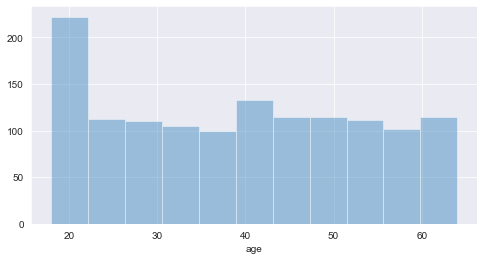

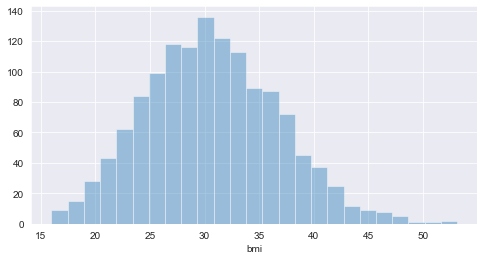

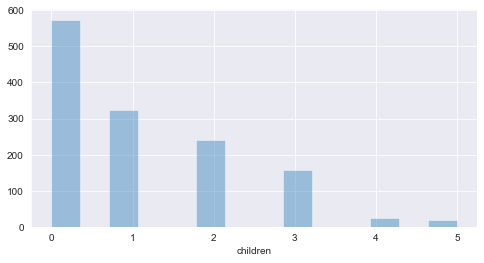

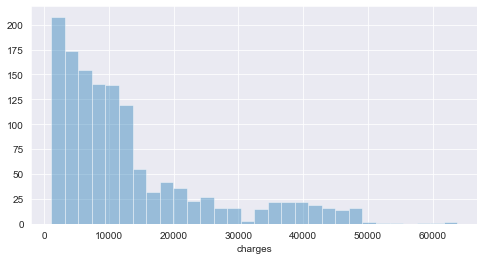

In [118]:
# Get all numerical columns
numerical_cols = [col for col in df_raw if np.issubdtype(df_raw[col].dtype, np.number)]
sns.set_style(style="darkgrid")

for col in numerical_cols:
    
    plt.figure(figsize=(8,4))
    sns.distplot(df_raw[col], kde=False)
    plt.show()

For age, I notice that it seems to be uniformly distributed except for having twice as many 18-22 year olds. This is something I would look more into if more info on the data were available. For bmi, there is a clear normal distribution around about 31. For children, most people have 3 or less. Finally, for charges we see that they decrease exponentially and that most are below $20,000. The median will be best for a measure of central tendency for this column.

Now that we have looked at the data and the columns, let's create some summary tables to see if we notice any patterns between the variables. For example, do there seem to be any differences between males and females? What about smokers and non-smokers? These are the kinds of questions I will look to begin answering by creating some simple tables. Later on we will explore these questions with some visualizations, but for now let's just look at tables.

In [119]:
df_raw.groupby('sex').mean()

,age,bmi,children,charges
sex,,,,
female,39.503021,30.377749,1.074018,12569.578844
male,38.917160,30.943129,1.115385,13956.751178


In [120]:
pd.DataFrame(df_raw.groupby(['sex','region']).count().iloc[:,0]).pivot_table(index='sex',columns='region').rename(columns={'age':'Region by Sex'})

Region by Sex                              
region     northeast northwest southeast southwest
sex                                               
female           161       164       175       162
male             163       161       189       163

From the tables above we can see that the data for male and females is very similar. There is about a 10% higher average for charges for males, so this may be something to take a deeper look at later on. The number of observations by region is mostly uniform, with a slightly higher amount in the Southeast region. Let's move on to smoking.

In [121]:
df_raw.groupby('smoker').mean()

,age,bmi,children,charges
smoker,,,,
no,39.385338,30.651795,1.090226,8434.268298
yes,38.514599,30.708449,1.113139,32050.231832


In [122]:
pd.DataFrame(df_raw.groupby(['smoker','region']).count().iloc[:,0]).pivot_table(index='smoker',columns='region').rename(columns={'smoker':'Region by Smoker'})

age                              
region northeast northwest southeast southwest
smoker                                        
no           257       267       273       267
yes           67        58        91        58

These tables paint a similar yet more severe picture. Smokers are similar across the board except for when it comes to charges. Smokers (as expected) pay much more, almost 4x as much on average. The regional table also shows a more significant difference in the Southeast region, having about 50% more smokers on average than any other region. Now let's combine sex and smoker to see if this opens up another layer of the data.

In [123]:
df_raw.groupby(['sex','smoker']).mean()

age        bmi  children       charges
sex    smoker                                              
female no      39.691042  30.539525  1.087751   8762.297300
       yes     38.608696  29.608261  1.008696  30678.996276
male   no      39.061896  30.770580  1.092843   8087.204731
       yes     38.446541  31.504182  1.188679  33042.005975

Again, there is not much deviation in any of the variables except for charges. From this table we can see that, of the non-smokers, females pay almost 10% more on average. Of the smokers, males pay about 8% more on average.

Now that we have a good understanding of the data and have looked at a few basic summary tables, let's explore it visually.

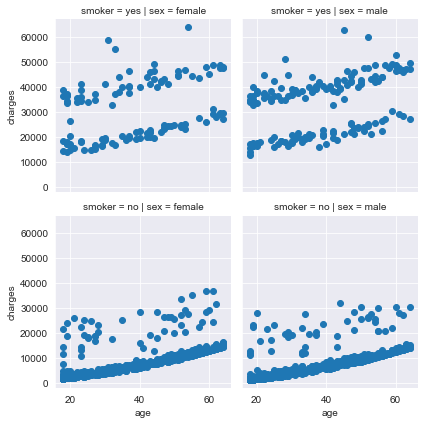

In [124]:
g = sns.FacetGrid(df_raw, col='sex', row='smoker')
g.map(plt.scatter, 'age', 'charges')

We can see a clear linear trend between age and charges across all combinations of smoker and sex. This is intuitive and lends me to think that age will be a significant feature to predict charges. One thing that stands out with this visual is the 2 separate clusters that are visible in the top charts (smoker = yes). Let's add in a 5th dimension to the data using color and see if region or children has anything to do with this.

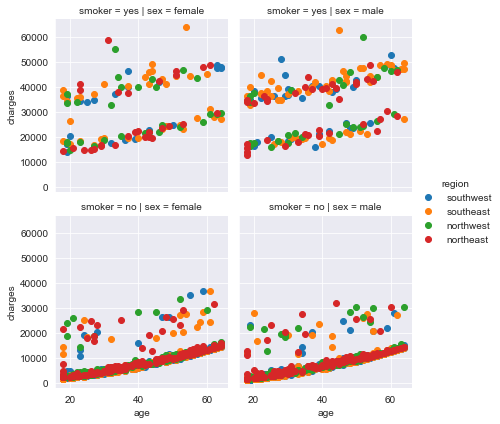

In [125]:
g = sns.FacetGrid(df_raw, col='sex', row='smoker', hue='region')
g.map(plt.scatter, 'age', 'charges').add_legend()

Region seems pretty random. We can see all 4 colors in both clusters, and the different colors seem to be roughly spread out evenly. Let's check the children column now.

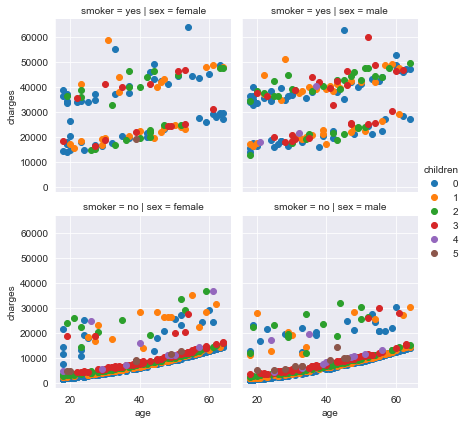

In [126]:
g = sns.FacetGrid(df_raw, col='sex', row='smoker', hue='children')
g.map(plt.scatter, 'age', 'charges').add_legend()

Again, there does not seem to be a relationship between the 2 clusters and the number of children. My guess is that the clusters are a result of the way that the data was simulated. This is the only explanation that I can find. Let's continue with more visualizations.

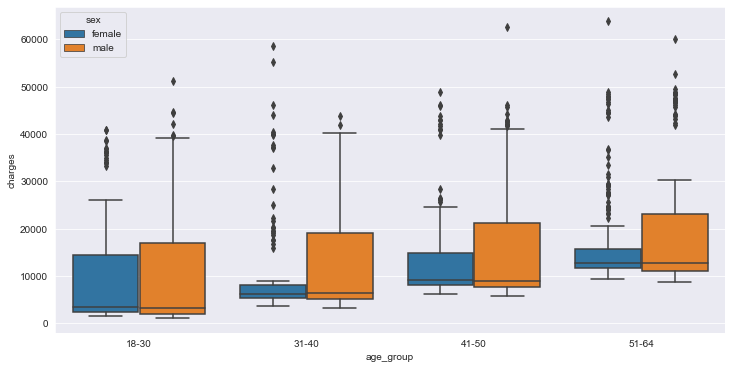

In [127]:
bins = [17,30,40,50,70]
df_raw['age_group'] = pd.cut(df_raw['age'], bins=bins, labels=['18-30','31-40','41-50','51-64'])

plt.figure(figsize=(12,6))
sns.boxplot(x='age_group', y='charges', hue='sex', data=df_raw)

This visualization again shows the positive linear trend between age and charges. It also sheds some light on the differences between the distributions of males and females. Males seem to have a wider distribution of charges when compared to females.

In [128]:
fig = px.sunburst(
    data_frame = df_raw,
    path = ['region', 'sex', 'smoker'],
    values = 'charges'
)
fig.update_layout(title_text='Charge Amount Demographics', title_x=0.5)
fig.show()

This is a sunburst chart in plotly. It is basically a multi-dimensional pie chart that is interactive. The proportions are based upon the total charges for each group. This chart helps visualize how evenly distributed all of the groups are. We can also visibly see how many more smokers there are in the southeast region, specifically males.

Let's move on to correlations now.

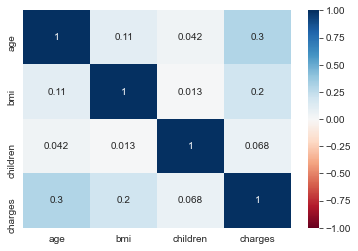

In [129]:
sns.heatmap(df_raw[numerical_cols].corr(), cmap = 'RdBu', vmin = -1, annot = True)

We can see that there isn't much correlation between charges and any of the quantitative variables. We know that smoker will be a significant factor in determining the charges, so perhaps the qualitative variables will do a better job. We will explore these as we create different linear regression models.

### Regression Analysis

Let's start our regression analysis. We need to make sure that our categorical variable of smoker is included in the regression model. For this, we will use the get_dummies function from pandas.

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [131]:
pd.get_dummies(df_raw)

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_group_18-30,age_group_31-40,age_group_41-50,age_group_51-64
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1,1,0,0,0
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0,1,0,0,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0,1,0,0,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,0,1,1,0,0,1,0,0,0,0,1,0
1334,18,31.920,0,2205.98080,1,0,1,0,1,0,0,0,1,0,0,0
1335,18,36.850,0,1629.83350,1,0,1,0,0,0,1,0,1,0,0,0
1336,21,25.800,0,2007.94500,1,0,1,0,0,0,0,1,1,0,0,0


To avoid multicollinearity, we need to drop some of the columns. When using get_dummies, we create n columns for n different groups of categorical variables. We only need to retain n-1 columns though. For example, the variable smoker has 2 groups (yes or no), so n=2. We only need to retain 1 column, because we know that a value of 0 in the smoker_yes column is the same thing as a value of 1 in the smoker_no column.

In [132]:
df_dum = pd.get_dummies(df_raw)
df_dum.drop(['age','sex_female','smoker_no','region_northeast','age_group_18-30'], axis=1, inplace=True)

Now we are ready to set up our linear regression model. First I will create a model using all of the variables that we have. Later on I will create a model using stepwise selection of variables.

In [133]:
X = df_dum.drop('charges', axis=1)
y = df_dum['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [134]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [135]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
bmi,335.143189
children,693.854115
sex_male,-33.360951
smoker_yes,23860.135387
region_northwest,-154.338024
region_southeast,-850.909832
region_southwest,-786.348715
age_group_31-40,1573.011663
age_group_41-50,4695.356890
age_group_51-64,8794.591921


Here we can see the coefficients for each feature. Again it appears that smoker and age are the most prominent factors. sklearn does not calculate the p-values, so we will look at p-values in our next model using the statsmodels library. Before we jump into that, let's take a look at how accurate our model is.

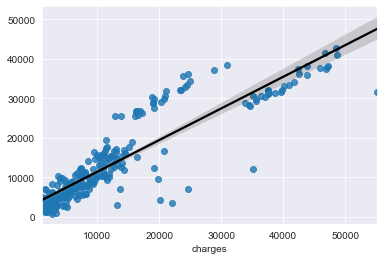

In [136]:
preds = lm.predict(X_test)
sns.regplot(y_test,preds,line_kws={'color':'black'})

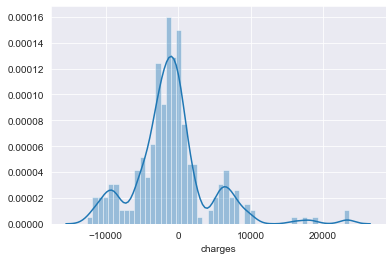

In [137]:
sns.distplot((y_test-preds),bins=50)

In [138]:
print('MAE:', metrics.mean_absolute_error(y_test, preds))
print('MSE:', metrics.mean_squared_error(y_test, preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, preds)))

RMSEs = []
RMSEs.append(np.sqrt(metrics.mean_squared_error(y_test, preds)))

MAE: 3761.114715734699
MSE: 28737358.780067686
RMSE: 5360.723717938436


We definitely have some variance in the residuals using this model. Ideally, the scatterplot above would show a strong correlation and would be as straight of a line as possible. The residuals appear to be centered around 0 or slightly less than 0, with some right skew present in the distribution. Our root mean squared error using this model is 5360, which I would say is not a very accurate model considering the median charge of $9,360. Let's try another model using stepwise selection of variables.

Since scikit-learn does not have a method for stepwise selection, we will have to create our own function. Luckily, there are plenty of resources on the web to help us. I found this function below on [StackOverflow](https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447).

In [210]:
import statsmodels.api as sm

data = df_dum
X = df_dum.drop('charges', axis=1)
y = df_dum['charges']


def stepwise_selection(X, y,
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = []
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = excluded[new_pval.argmin()]
            # below is returning a 4 instead of a column name?? should be returning 'smoker_yes'
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

C:\Users\Tristan\anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Add  smoker_yes                     with p-value 8.27144e-283
Add  age_group_51-64                with p-value 3.07625e-63
Add  bmi                            with p-value 6.15929e-30
Add  age_group_41-50                with p-value 3.00725e-21
Add  children                       with p-value 1.12867e-07
Add  age_group_31-40                with p-value 0.000387584
resulting features:
['smoker_yes', 'age_group_51-64', 'bmi', 'age_group_41-50', 'children', 'age_group_31-40']


Great! Now that we have our selected features, let's run the same regression as above except this time we will only use the features selected by our stepwise_selection function.

In [211]:
X = df_dum[result]
y = df_dum['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [212]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [213]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
smoker_yes,23844.685055
age_group_51-64,8830.354783
bmi,319.075740
age_group_41-50,4691.651304
children,699.211498
age_group_31-40,1567.980794


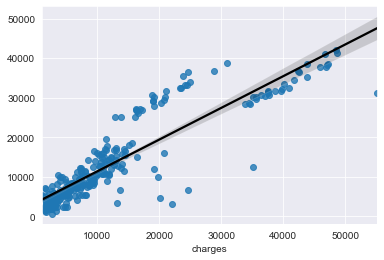

In [214]:
preds = lm.predict(X_test)
sns.regplot(y_test,preds,line_kws={'color':'black'})

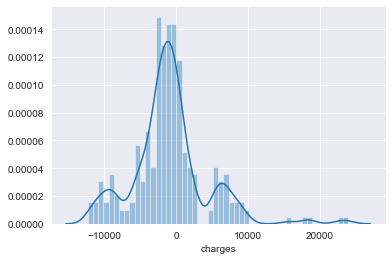

In [144]:
sns.distplot((y_test-preds),bins=50)

In [145]:
print('MAE:', metrics.mean_absolute_error(y_test, preds))
print('MSE:', metrics.mean_squared_error(y_test, preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, preds)))

RMSEs.append(np.sqrt(metrics.mean_squared_error(y_test, preds)))

MAE: 3799.9515390877314
MSE: 29052756.271343537
RMSE: 5390.060878259496


Our new model is actually slightly less accurate than our original one. Let's move on to predicting whether or not someone is a smoker. This should be a much more accurate model given that we know the charges for a smoker are significantly more than a non-smoker.

### Machine Learning

There are a number of different models that we could try. For this analysis I will focus on a random forest and an xgboost model. Let's start with a random forest. For more information on what a random forest is and how it works, check out this [article](https://towardsdatascience.com/understanding-random-forest-58381e0602d2#:~:text=The%20random%20forest%20is%20a,that%20of%20any%20individual%20tree.).

In [146]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Let's revisit our original data frame before we created dummy variables. We will be using the original data for our machine learning models.

In [147]:
df_raw.head()

,age,sex,bmi,children,smoker,region,charges,age_group
0,19,female,27.900,0,yes,southwest,16884.92400,18-30
1,18,male,33.770,1,no,southeast,1725.55230,18-30
2,28,male,33.000,3,no,southeast,4449.46200,18-30
3,33,male,22.705,0,no,northwest,21984.47061,31-40
4,32,male,28.880,0,no,northwest,3866.85520,31-40


We know that the variable we are trying to predict is smoker. Before we begin preprocessing, I am going to convert this column to be numerical. After that, I will split up the variables based upon whether they are numerical or categorical. Finally, I will drop age_group.

In [148]:
df_ml = df_raw
df_ml['smoker'] = df_ml['smoker'].map({'yes':1,'no':0})
df_ml.drop('age_group', axis=1, inplace=True)
df_ml.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520


Now we are ready to create our preprocessing pipeline for our random forest model. See the documentation [here](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html) for the format that I will follow. I will also be performing k-fold cross validation to help control our model's bias and to make it more robust.

In [149]:
num_feats = ['age', 'bmi', 'children', 'charges']
cat_feats = ['sex','region']
feats = num_feats + cat_feats

X = df_ml.drop('smoker', axis = 1)[feats]
y = df_ml['smoker']

num_trans = SimpleImputer(strategy='constant')
cat_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                            ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_trans, num_feats),
        ('cat', cat_trans, cat_feats)])

k = 4
ksplit = KFold(n_splits=k, shuffle=True, random_state=13)

Let's run our model and see how accurate it is!

In [150]:
rfc_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state = 13))])

cross_val = cross_val_score(rfc_model, X, y, cv = ksplit, scoring='accuracy', n_jobs=-1)
print("Accuracy: %.3f" % np.mean(cross_val))

Accuracy: 0.947


As expected, our accurary at predicting whether or not someone is a smoker is much more accurate. Let's see if an xgboost model has even better results. Check out [this](https://xgboost.readthedocs.io/en/latest/parameter.html) article or [this](https://www.datacamp.com/community/tutorials/xgboost-in-python) one to read about the basics of the model. Note that since we are not running a preprocessing pipeline I will use the df with the categorical variables as dummy variables (df_dum).

In [151]:
import xgboost as xgb

In [152]:
X = df_dum.drop('smoker_yes', axis=1)
y = df_dum['smoker_yes']
xgb_matrix = xgb.DMatrix(data=X,label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

The two cells below can be executed to perform cross validation (CV) for our model and see the results. I could not figure out how to view the tree diagram or see the feature importances using this method, so I will also use the method without CV.

In [153]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.8,'learning_rate': 0.1,'subsample': 0.8,
          'max_depth': 10, 'alpha': 1}

cv_results = xgb.cv(dtrain=xgb_matrix, params=params, nfold=4,num_boost_round=100,early_stopping_rounds=5,
                    metrics="error", as_pandas=True, seed=13)

In [154]:
cv_results.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.033881,0.001717,0.049332,0.016725
1,0.030394,0.001495,0.043344,0.011260
2,0.028899,0.003156,0.044834,0.012107
3,0.026656,0.004127,0.042600,0.011446
4,0.028401,0.005570,0.047082,0.006086


Here is the method without CV.

In [155]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',colsample_bytree = 0.8,learning_rate = 0.1,subsample = 0.8,
                              max_depth = 10,alpha = 1,n_estimators=10)
xgb_model.fit(X_train,y_train)
preds = xgb_model.predict(X_test)

print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       211
           1       0.93      0.96      0.95        57

    accuracy                           0.98       268
   macro avg       0.96      0.97      0.97       268
weighted avg       0.98      0.98      0.98       268



As we can see, the XGBoost model performed even better than just our Random Forest, with an accuracy of 98%! One of my favorite features about XGBoost is being able to easily see which features were most important and also being able to visualize the tree diagram. This helps to interpret the model, which is extremely important.

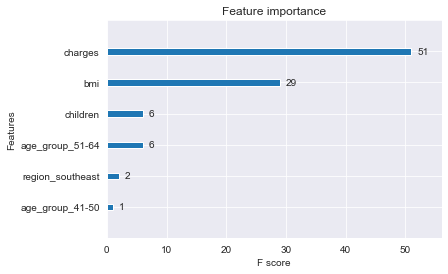

In [156]:
xgb.plot_importance(xgb_model)

As expected, charges was the most important feature to predict whether or not the person was a smoker. We can see that bmi was also an important factor.

C:\Users\Tristan\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



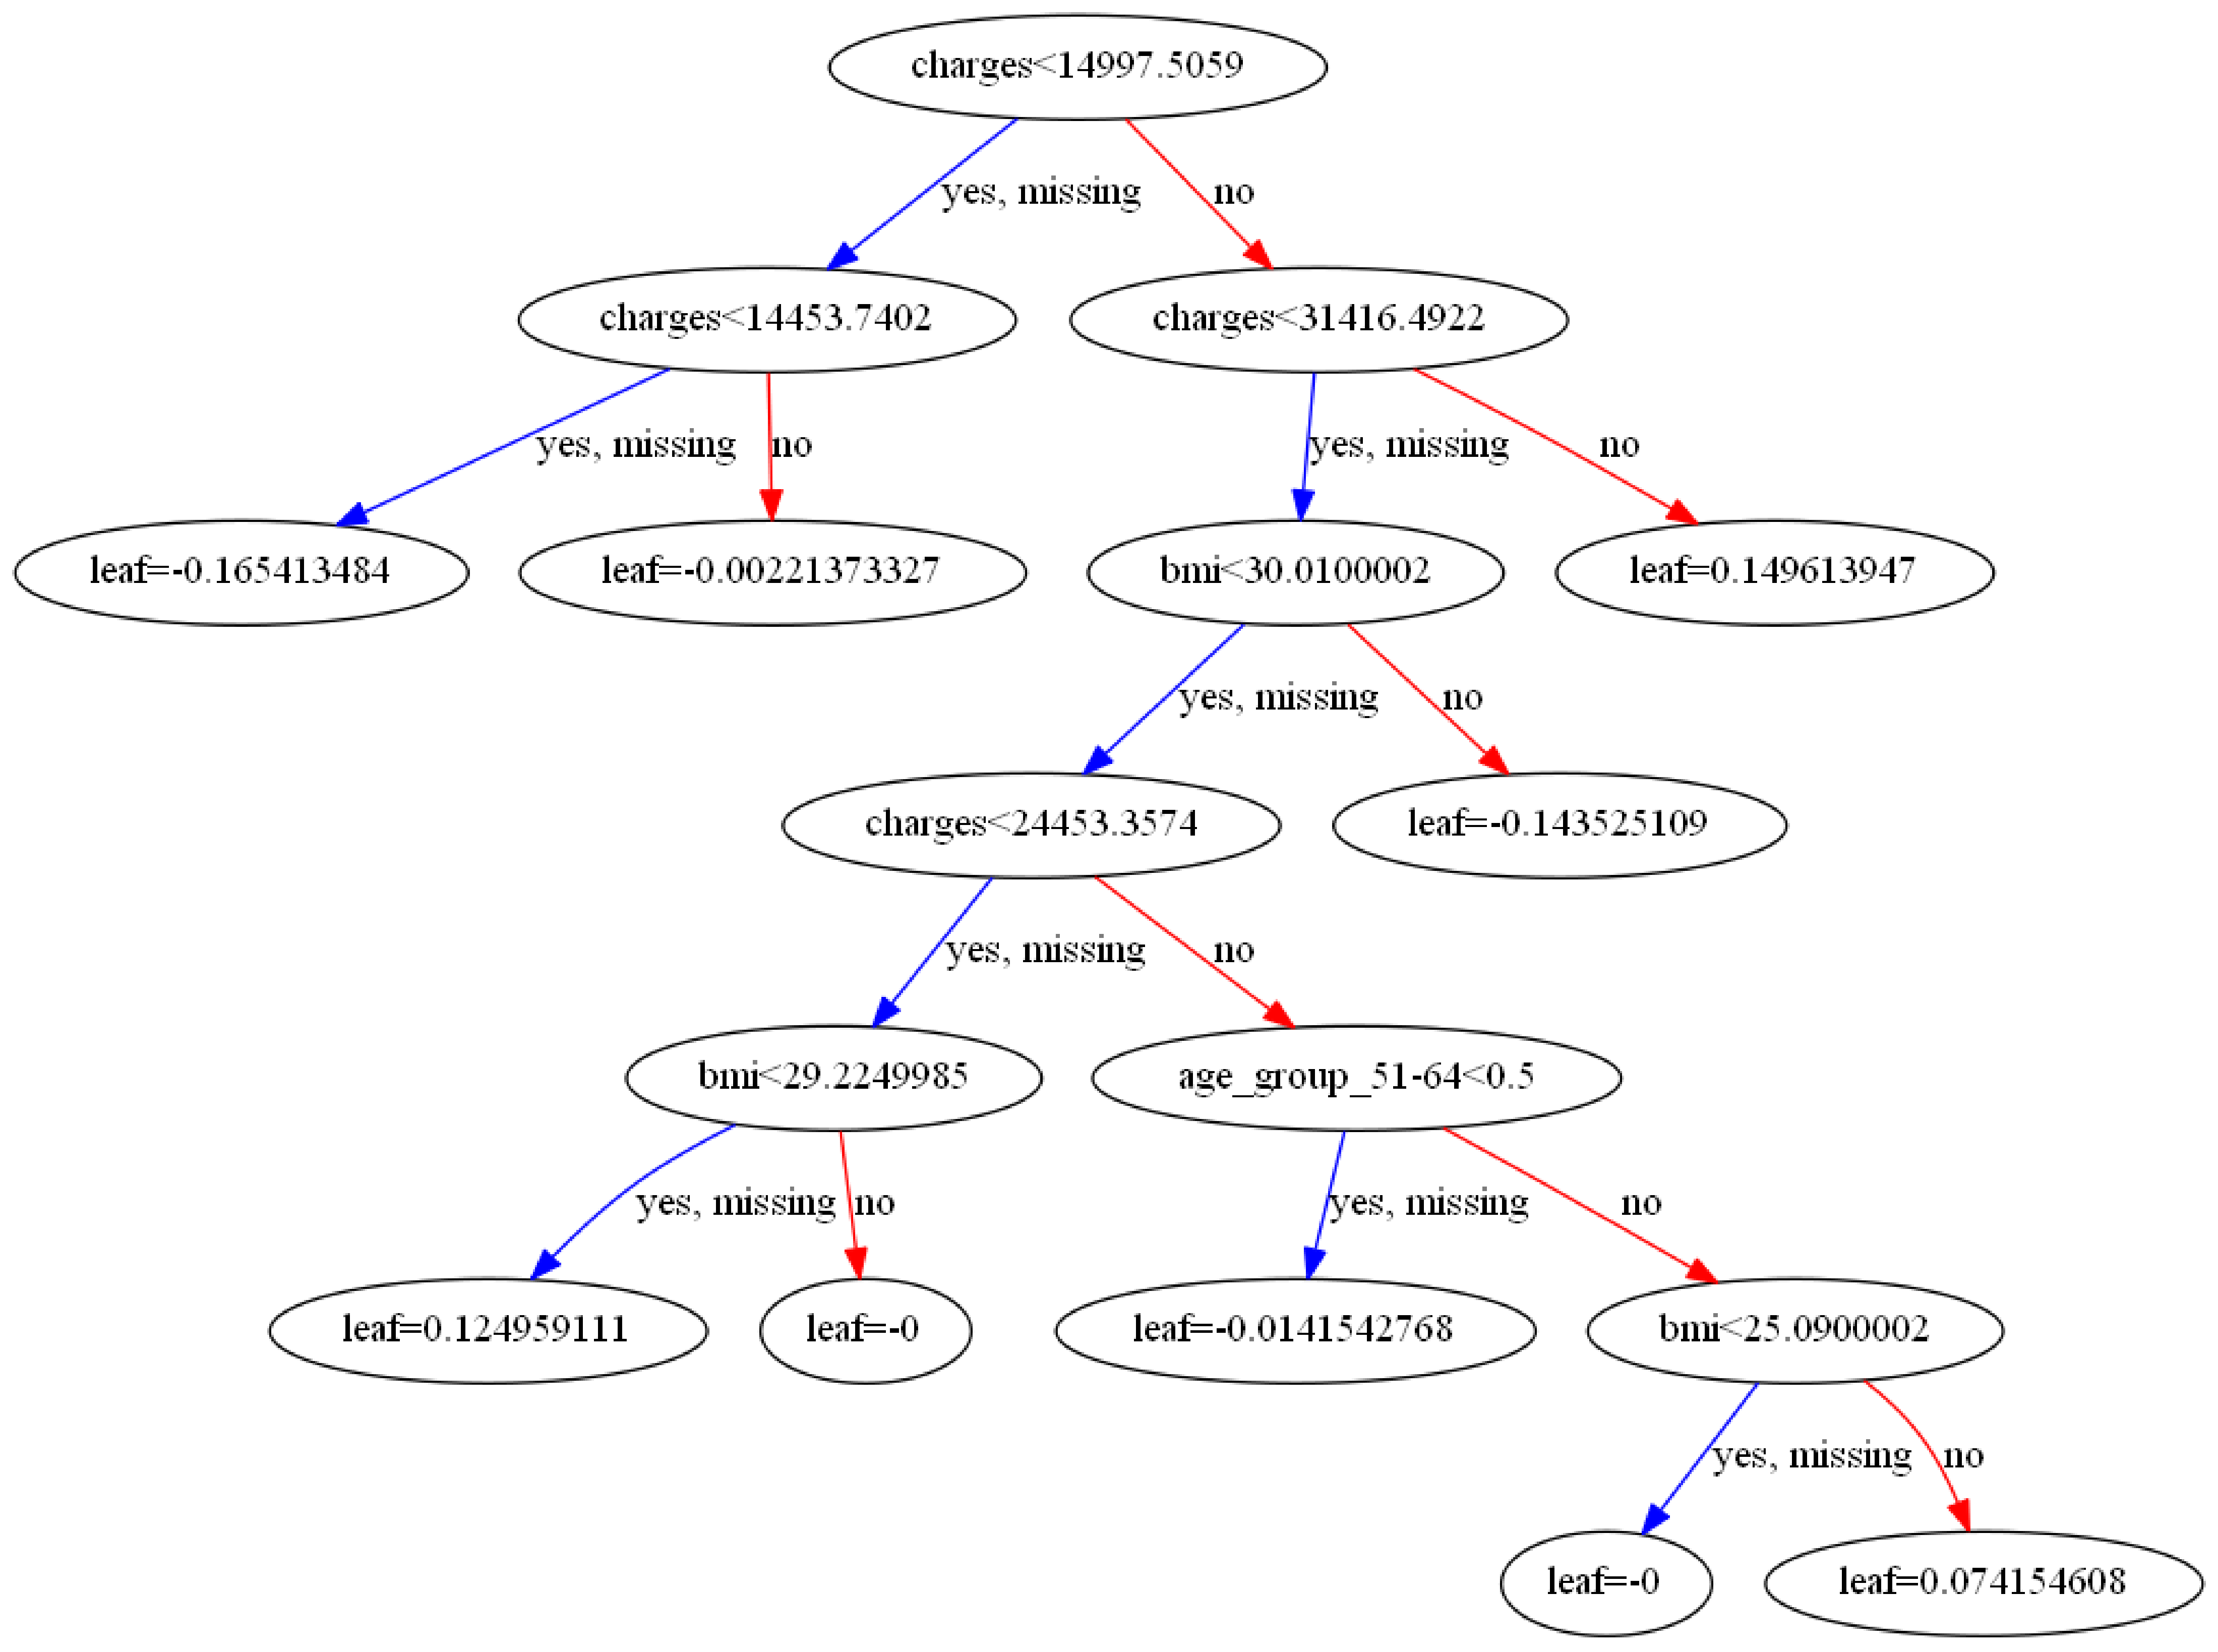

In [157]:
xgb.plot_tree(xgb_model,num_trees=2) # use rankdir='LR' for a horizontal tree
fig = plt.gcf()
fig.set_size_inches(90, 60)
fig.show()

And now we have a visualization of our tree model and how it is making decisions. Note that the top two layers use charges. Tree diagrams work by finding the feature that most explains the variability in the data first and then working it's way down. The fact that charges is the feature that is used for decisions in the first two layers just shows us again how important it is in this dataset.

We were able to accurately predict the smoker label with both of our models. Now we will move on to creating a neural network to hopefully predict the charges variable more accurately than our previous regression models.

### Deep Learning

Neural networks, which are the structure of deep learning, are a truly fascinating concept. We are basically going to create a brain for the computer, give it some guidelines on how to quantify accuracy, and then let it think and find the best route to a solution. For a more thorough explanation, see [this](https://news.mit.edu/2017/explained-neural-networks-deep-learning-0414).

In [158]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

In [159]:
X = df_dum.drop('charges', axis=1)
y = df_dum['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

We'll make a couple of different neural networks and see how they compare to our original linear model. Note that we have 10 input columns (X), so we will need the same amount of nodes for our input layer.

In [181]:
nn_model = Sequential()
nn_model.add(Dense(10, input_dim=X.shape[1], activation='relu'))
nn_model.add(Dense(5, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)

nn_model.fit(X_train,y_train,validation_data=(X_test,y_test),verbose=2,epochs=500,batch_size=10,callbacks=[monitor])

Epoch 1/500
107/107 - 0s - loss: 328944096.0000 - val_loss: 296665440.0000
Epoch 2/500
107/107 - 0s - loss: 328082848.0000 - val_loss: 295506048.0000
Epoch 3/500
107/107 - 0s - loss: 326215168.0000 - val_loss: 293080960.0000
Epoch 4/500
107/107 - 0s - loss: 322560160.0000 - val_loss: 288644224.0000
Epoch 5/500
107/107 - 0s - loss: 316471360.0000 - val_loss: 281654560.0000
Epoch 6/500
107/107 - 0s - loss: 307612736.0000 - val_loss: 272002272.0000
Epoch 7/500
107/107 - 0s - loss: 295767648.0000 - val_loss: 259895504.0000
Epoch 8/500
107/107 - 0s - loss: 281213888.0000 - val_loss: 245236640.0000
Epoch 9/500
107/107 - 0s - loss: 264351760.0000 - val_loss: 229117760.0000
Epoch 10/500
107/107 - 0s - loss: 246002192.0000 - val_loss: 211873856.0000
Epoch 11/500
107/107 - 0s - loss: 227073904.0000 - val_loss: 194940320.0000
Epoch 12/500
107/107 - 0s - loss: 208794288.0000 - val_loss: 179035264.0000
Epoch 13/500
107/107 - 0s - loss: 191904752.0000 - val_loss: 165280560.0000
Epoch 14/500
107/107 

Epoch 109/500
107/107 - 0s - loss: 125393992.0000 - val_loss: 118715120.0000
Epoch 110/500
107/107 - 0s - loss: 125191688.0000 - val_loss: 118454640.0000
Epoch 111/500
107/107 - 0s - loss: 125006112.0000 - val_loss: 118329256.0000
Epoch 112/500
107/107 - 0s - loss: 124814880.0000 - val_loss: 118169712.0000
Epoch 113/500
107/107 - 0s - loss: 124629600.0000 - val_loss: 117980848.0000
Epoch 114/500
107/107 - 0s - loss: 124421424.0000 - val_loss: 117736160.0000
Epoch 115/500
107/107 - 0s - loss: 124240280.0000 - val_loss: 117554888.0000
Epoch 116/500
107/107 - 0s - loss: 124065464.0000 - val_loss: 117411560.0000
Epoch 117/500
107/107 - 0s - loss: 123840496.0000 - val_loss: 117125960.0000
Epoch 118/500
107/107 - 0s - loss: 123629432.0000 - val_loss: 116962544.0000
Epoch 119/500
107/107 - 0s - loss: 123442496.0000 - val_loss: 116791664.0000
Epoch 120/500
107/107 - 0s - loss: 123263584.0000 - val_loss: 116564800.0000
Epoch 121/500
107/107 - 0s - loss: 123031992.0000 - val_loss: 116373464.0000

Epoch 217/500
107/107 - 0s - loss: 85237776.0000 - val_loss: 77989136.0000
Epoch 218/500
107/107 - 0s - loss: 84531480.0000 - val_loss: 77264712.0000
Epoch 219/500
107/107 - 0s - loss: 83822040.0000 - val_loss: 76589984.0000
Epoch 220/500
107/107 - 0s - loss: 83130464.0000 - val_loss: 75778416.0000
Epoch 221/500
107/107 - 0s - loss: 82378832.0000 - val_loss: 75069352.0000
Epoch 222/500
107/107 - 0s - loss: 81638840.0000 - val_loss: 74247688.0000
Epoch 223/500
107/107 - 0s - loss: 80911048.0000 - val_loss: 73583752.0000
Epoch 224/500
107/107 - 0s - loss: 80155320.0000 - val_loss: 72809008.0000
Epoch 225/500
107/107 - 0s - loss: 79443112.0000 - val_loss: 71983608.0000
Epoch 226/500
107/107 - 0s - loss: 78670616.0000 - val_loss: 71285168.0000
Epoch 227/500
107/107 - 0s - loss: 77925176.0000 - val_loss: 70441008.0000
Epoch 228/500
107/107 - 0s - loss: 77153856.0000 - val_loss: 69667856.0000
Epoch 229/500
107/107 - 0s - loss: 76394784.0000 - val_loss: 68915792.0000
Epoch 230/500
107/107 - 0

Epoch 327/500
107/107 - 0s - loss: 40553672.0000 - val_loss: 31078752.0000
Epoch 328/500
107/107 - 0s - loss: 40522104.0000 - val_loss: 31153780.0000
Epoch 329/500
107/107 - 0s - loss: 40489824.0000 - val_loss: 31065214.0000
Epoch 330/500
107/107 - 0s - loss: 40488040.0000 - val_loss: 31012004.0000
Epoch 331/500
107/107 - 0s - loss: 40449644.0000 - val_loss: 30878782.0000
Epoch 332/500
107/107 - 0s - loss: 40429068.0000 - val_loss: 30924972.0000
Epoch 333/500
107/107 - 0s - loss: 40399128.0000 - val_loss: 30964278.0000
Epoch 334/500
107/107 - 0s - loss: 40387516.0000 - val_loss: 31001200.0000
Epoch 335/500
107/107 - 0s - loss: 40318772.0000 - val_loss: 30681234.0000
Epoch 336/500
107/107 - 0s - loss: 40334364.0000 - val_loss: 30806250.0000
Epoch 337/500
107/107 - 0s - loss: 40296804.0000 - val_loss: 30729928.0000
Epoch 338/500
107/107 - 0s - loss: 40294184.0000 - val_loss: 30836244.0000
Epoch 339/500
107/107 - 0s - loss: 40224764.0000 - val_loss: 30469694.0000
Epoch 340/500
107/107 - 0

In [182]:
pred = nn_model.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(pred,y_test)))
RMSEs.append(np.sqrt(metrics.mean_squared_error(pred,y_test)))

RMSE: 5519.936146724641


Let's tweak the neural network and see if we can do better. In the next model, I will increase the first hidden layer size to 20, increase the following hidden layer size to 10, and then add 2 more hidden layers with 5 nodes.

In [183]:
nn_model2 = Sequential()
nn_model2.add(Dense(20, input_dim=X.shape[1], activation='relu'))
nn_model2.add(Dense(10, activation='relu'))
nn_model2.add(Dense(10, activation='relu'))
nn_model2.add(Dense(5, activation='relu'))
nn_model2.add(Dense(5, activation='relu'))
nn_model2.add(Dense(1))
nn_model2.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)

nn_model2.fit(X_train,y_train,validation_data=(X_test,y_test),verbose=2,epochs=1000,batch_size=5,callbacks=[monitor])

Epoch 1/1000
214/214 - 0s - loss: 324269760.0000 - val_loss: 274367584.0000
Epoch 2/1000
214/214 - 0s - loss: 207811648.0000 - val_loss: 131332096.0000
Epoch 3/1000
214/214 - 0s - loss: 138578096.0000 - val_loss: 130364232.0000
Epoch 4/1000
214/214 - 0s - loss: 137408464.0000 - val_loss: 129552248.0000
Epoch 5/1000
214/214 - 0s - loss: 136592384.0000 - val_loss: 129259352.0000
Epoch 6/1000
214/214 - 0s - loss: 135907968.0000 - val_loss: 128455360.0000
Epoch 7/1000
214/214 - 0s - loss: 134759392.0000 - val_loss: 127117984.0000
Epoch 8/1000
214/214 - 0s - loss: 134195464.0000 - val_loss: 126797544.0000
Epoch 9/1000
214/214 - 0s - loss: 133827512.0000 - val_loss: 125210768.0000
Epoch 10/1000
214/214 - 0s - loss: 132203736.0000 - val_loss: 126579248.0000
Epoch 11/1000
214/214 - 0s - loss: 131133832.0000 - val_loss: 123383512.0000
Epoch 12/1000
214/214 - 0s - loss: 130344472.0000 - val_loss: 123009976.0000
Epoch 13/1000
214/214 - 0s - loss: 129249040.0000 - val_loss: 122548536.0000
Epoch 14

In [184]:
pred = nn_model2.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(pred,y_test)))
RMSEs.append(np.sqrt(metrics.mean_squared_error(pred,y_test)))

RMSE: 5402.765621728061


In [209]:
cols = ['linear_reg','linear_reg_stepwise','nn1','nn2']
RMSEs = pd.DataFrame(RMSEs).transpose()
RMSEs.columns = cols
RMSEs

,linear_reg,linear_reg_stepwise,nn1,nn2
0,5360.723718,5390.060878,5519.936147,5402.765622


So it looks like our original regression model performed the best. Sometimes the simplest model is best, although I would not say that our regression model is very accurate. Again, I think there was some assumption made when simulating this data that is causing those 2 clusters we noticed, which makes our model more inaccurate.

### Recap

Here is a recap of what we did:
1. We thoroughly reviewed our data and explored any potential relationships before we created any models or made any assumptions
2. We then created a couple of regression models to predict the charges column
3. We created a couple of machine learning models to predict the smoker column
4. Finally, we attempted to create a neural network to better predict the charges column

Thanks for following along! Feel free to reach out to me with any tips/comments. My email is tmf13@my.fsu.edu.